In [1]:
import numpy as np 
import pandas as pd 
import matplotlib .pyplot as plt 
import seaborn as sns
import re

import nltk 
from nltk import RegexpTokenizer 
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('wordnet')

import html 
import collections 
from collections import Counter 

# !pip install wordcloud 
import wordcloud 
from wordcloud import WordCloud 

from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.model_selection import train_test_split 

import warnings
warnings.filterwarnings("ignore")
import copy
from xgboost import XGBClassifier

## Importing Original Data
The purpose of this assignment is to compute the sentiment of tweets posted in 2019 Canadian Elections and answer the question: “What can public opinion on Twitter tell us about the Canadian political landscape in 2019?” 

The are two input files: 
1) sentiment_analysis.csv : 550391 labeled generic tweets with the following column: 0-ID, 1-text, 2-label

2) Canadian_election_2019.csv: 2133 labeled tweets related to the election, with the following column: 0 - sentiment, 1 - negative_reason, 2 - text

In [2]:
#import data
input_SA = 'sentiment_analysis.csv'
input_CE19 = 'Canadian_elections_2019.csv'
SA = pd.read_csv(input_SA, low_memory = False)
Election = pd.read_csv(input_CE19, low_memory = False)

In [3]:
SA.head()

,ID,text,label
0,7.680980e+17,Josh Jenkins is looking forward to TAB Breeder...,1
1,7.680980e+17,RT @MianUsmanJaved: Congratulations Pakistan o...,1
2,7.680980e+17,"RT @PEPalerts: This September, @YESmag is taki...",1
3,7.680980e+17,"RT @david_gaibis: Newly painted walls, thanks ...",1
4,7.680980e+17,RT @CedricFeschotte: Excited to announce: as o...,1


In [4]:
Election.head()

,sentiment,negative_reason,text
0,negative,Women Reproductive right and Racism,"b""@RosieBarton So instead of your suggestion, ..."
1,positive,NaN,"b""#AllWomanSpacewalk it's real!\n@Space_Statio..."
2,negative,Economy,"b""#Brantford It's going to cost YOU $94 BILLIO..."
3,positive,NaN,"b""#Canada #CanadaElection2019 #CanadaVotes \n#..."
4,negative,Economy,"b""#Canada #taxpayers are sick &amp; tired of h..."


## Data Cleaning


**Procedure:**: 
1. Remove b at the beginning of feature 'text' in the Election dataset. It is just indication of data types of bytes.And also the quotation mark around it. 
2. Remove emojis. 
3. All html tags and attributes (i.e., /<[^>]+>/) are removed.
4. Html character codes (i.e., &...;) are replaced with an ASCII equivalent.
5. All URLs are removed.
6. All characters in the text are in lowercase.
7. All stop words are removed. Be clear in what you consider as a stop word. 
8. If a tweet is empty after pre-processing, it should be preserved as such.


In [5]:
def remove_b(tweets):
    tweets = str(tweets)
    return tweets[2:-1]

Election['text_c'] = Election['text'].apply(remove_b)
Election.head()

,sentiment,negative_reason,text,text_c
0,negative,Women Reproductive right and Racism,"b""@RosieBarton So instead of your suggestion, ...","@RosieBarton So instead of your suggestion, ho..."
1,positive,NaN,"b""#AllWomanSpacewalk it's real!\n@Space_Statio...",#AllWomanSpacewalk it's real!\n@Space_Station ...
2,negative,Economy,"b""#Brantford It's going to cost YOU $94 BILLIO...",#Brantford It's going to cost YOU $94 BILLION ...
3,positive,NaN,"b""#Canada #CanadaElection2019 #CanadaVotes \n#...",#Canada #CanadaElection2019 #CanadaVotes \n#el...
4,negative,Economy,"b""#Canada #taxpayers are sick &amp; tired of h...",#Canada #taxpayers are sick &amp; tired of hav...


In [6]:
def remove_emoji(tweets):
    return re.sub(r'(\\x(.){2})', '', tweets) 

Election['text_c'] = Election['text_c'].apply(remove_emoji)
Election.head()

,sentiment,negative_reason,text,text_c
0,negative,Women Reproductive right and Racism,"b""@RosieBarton So instead of your suggestion, ...","@RosieBarton So instead of your suggestion, ho..."
1,positive,NaN,"b""#AllWomanSpacewalk it's real!\n@Space_Statio...",#AllWomanSpacewalk it's real!\n@Space_Station ...
2,negative,Economy,"b""#Brantford It's going to cost YOU $94 BILLIO...",#Brantford It's going to cost YOU $94 BILLION ...
3,positive,NaN,"b""#Canada #CanadaElection2019 #CanadaVotes \n#...",#Canada #CanadaElection2019 #CanadaVotes \n#el...
4,negative,Economy,"b""#Canada #taxpayers are sick &amp; tired of h...",#Canada #taxpayers are sick &amp; tired of hav...


In [9]:
# Remove html tags and attributes
def remove_tags(tweet):
    tags = re.compile(r'/<[^>]+>/')
    return re.sub(tags, ' ', str(tweet))

# Replace html with ASCII equivalent
def html_ascii(tweet):
    return html.unescape(tweet)

# Remove all URLs
def remove_url(tweet):
    urls = re.compile(r'(https?t?:\/\/)(\s)*(www\.)?(\s)*((\w|\s)+\.)*([\w\-\s]+\/)*([\w\-]+)((\?)?[\w\s]*=\s*[\w\%&]*)*')
    return re.sub(urls, ' ', str(tweet))

# Make all characters lower case
def lowercase(tweet):
    return tweet.lower()

# Before remove the stopwords, tokenize the tweets first
def tokenize(tweet):
    tok_tweet = nltk.tokenize.word_tokenize(tweet)
    return ' '.join(tok_tweet)

def remove_stopwords(tweet):
    words = tweet.split()
    clean_tweet = [word for word in words if word not in stopwords.words('english')]
    return ' '.join(clean_tweet)

def remove_nonAlphaNum(tweet):
    return re.sub(r'[^\s\w]+', '', tweet)

def remove_rt(tweet):
    return re.sub(r'\brt\b','', str(tweet) )


def remove_sw(tweet):
#     stop_words = stopwords.words('english')
#     stopwords_dict = Counter(stop_words)
    cachedStopWords = stopwords.words('english')
    return ' '.join([word for word in text.split() if word not in cachedStopWords])

def preprocessing(tweet):
    tweet = remove_tags(tweet)
    tweet = html_ascii(tweet)
    tweet = remove_url(tweet)
    tweet = lowercase(tweet)
    tweet = remove_nonAlphaNum(tweet)
    tweet = tokenize(tweet)
    tweet = remove_stopwords(tweet)
#     tweet = remove_sw(tweet)
    tweet = remove_rt(tweet)
    return tweet

In [10]:
SA['text_c'] = SA['text'].apply(preprocessing)
Election['text_c'] = Election['text_c'].apply(preprocessing)
Election

,sentiment,negative_reason,text,text_c
0,negative,Women Reproductive right and Racism,"b""@RosieBarton So instead of your suggestion, ...",rosiebarton instead suggestion agree canadian ...
1,positive,NaN,"b""#AllWomanSpacewalk it's real!\n@Space_Statio...",allwomanspacewalk realnspace_station netobicok...
2,negative,Economy,"b""#Brantford It's going to cost YOU $94 BILLIO...",brantford going cost 94 billion next 4 years a...
3,positive,NaN,"b""#Canada #CanadaElection2019 #CanadaVotes \n#...",canada canadaelection2019 canadavotes nelxn43 ...
4,negative,Economy,"b""#Canada #taxpayers are sick &amp; tired of h...",canada taxpayers sick tired hard earned donate...
...,...,...,...,...
2128,negative,Scandal,b'You know he was doing a good enough job smea...,know good enough job smearing campaign right a...
2129,negative,Scandal,b'You missed the comment. Deflecting the issue...,missed comment deflecting issue answer best re...
2130,positive,NaN,b'Your daily reminder:\n@theJagmeetSingh endor...,daily remindernthejagmeetsingh endorses strate...
2131,negative,Women Reproductive right and Racism,b'Yup...not going to reopen the abortion debat...,yupnot going reopen abortion debatenelxn43 sch...


## 2.0 Exploratory Analysis

### 2.1 Label Tweet with Associated Political Party

Relevant words and hashtags for political parties involved in election
1. Liberal party: 
   - Leader: Justin Trudeau, twitter account: @JustinTrudeau
   - Slogan: "chooseforward"
   - Official hashtag: #lpc 
<br>
<br>
2. Conservative party:
   - Leader: Andrew Scheer, twitter account: @AndrewScheer
   - Slogan: "It's time for you to get ahead."
   - official hashtag: #cpc
<br>
<br>
3. Bloc Québécois: 
   - Leader: Yves-François Blanchet, twitter account: @yfblanchet
   - Slogan: "Quebec, it is us"
   - official hashtag: #ptbloc
<br>
<br>
4. New Democratic:
   - Leader: Jagmeet Singh, twitter account: @theJagmeetSingh
   - Slogan: "In it for you"
   - official hashtag: #ptndp
<br>
<br>
5. Green party: 3
   - Leader: Elizabeth May, twitter account: @ElizabethMay
   - Slogan: "Not left. Not right. Forward together"
   - official hashtag: #ptgreen

In [12]:
E_df = copy.deepcopy(Election)
E_df.drop(['text'], axis =1, inplace= True)

**Procedure:**
1. Create strings that contains the keywords and hashtags for each parties
2. Create a new column for each party. The value of these feature represents if the tweets is affiliated with the party. It contains true and false. Similar to one-hot encoding. 

**Justification:** 
Using one-hot encoding, each tweet can be labeled true for two or more parties since it is likely that the tweet mentioned multiple parties and compared them in one single tweet. Tweet with 5 false labels is determined as not relevant to the election. <br>
However, this method may introduce bias and error due to mislabel. A tweet related to parties may not contain the keywords presented in the keyword list. It may decrease the model prediction accuracy slightly.

In [13]:
kw_lib = 'justin|trudeau|justintrudeau|liberal|lpc|chooseforward'
kw_cons = 'andrew|scheer|andrewscheer|conservative|cpc|getahead'
kw_bq = 'yves|françois|francois|blanchet|yfblanchet|yvesfrançoisblanchet|bloc|québécois|bq|ptbloc|quebec'
kw_ndp = 'jagmeet|singh|jagmeetsingh|thejagmeetsingh|ndp|democratic|ptndp|initforyou'
kw_green = 'elizabeth|may|elizabethmay|green|greenparty|ptgreen|notleft|notright|forwardtogether'

#create list of ketwords 
keywords = [kw_lib, kw_cons, kw_bq, kw_bq, kw_ndp, kw_green]

#create list of parties 
parties = ['Liberal', 'Conservative', 'Bloc Québécois', 'New Democratic', 'Green']

for party, keyword in zip(parties, keywords):
    E_df[party]= E_df['text_c'].str.contains(keyword)
E_df

,sentiment,negative_reason,text_c,Liberal,Conservative,Bloc Québécois,New Democratic,Green
0,negative,Women Reproductive right and Racism,rosiebarton instead suggestion agree canadian ...,False,True,False,False,False
1,positive,NaN,allwomanspacewalk realnspace_station netobicok...,False,False,False,False,False
2,negative,Economy,brantford going cost 94 billion next 4 years a...,True,False,False,False,False
3,positive,NaN,canada canadaelection2019 canadavotes nelxn43 ...,False,False,False,False,False
4,negative,Economy,canada taxpayers sick tired hard earned donate...,True,False,False,False,False
...,...,...,...,...,...,...,...,...
2128,negative,Scandal,know good enough job smearing campaign right a...,False,True,False,False,False
2129,negative,Scandal,missed comment deflecting issue answer best re...,False,True,False,False,False
2130,positive,NaN,daily remindernthejagmeetsingh endorses strate...,True,False,False,False,True
2131,negative,Women Reproductive right and Racism,yupnot going reopen abortion debatenelxn43 sch...,False,True,False,False,False


In [12]:
E_df[parties] = E_df[parties].astype(int)
E_df.head()

,sentiment,negative_reason,text_c,Liberal,Conservative,Bloc Québécois,New Democratic,Green
0,negative,Women Reproductive right and Racism,rosiebarton instead suggestion agree canadian ...,0,1,0,0,0
1,positive,NaN,allwomanspacewalk realnspace_station netobicok...,0,0,0,0,0
2,negative,Economy,brantford going cost 94 billion next 4 years a...,1,0,0,0,0
3,positive,NaN,canada canadaelection2019 canadavotes nelxn43 ...,0,0,0,0,0
4,negative,Economy,canada taxpayers sick tired hard earned donate...,1,0,0,0,0


#### Distribution of Political Affiliation of Tweets 

**2019 Election Results**
1. Liberal party: 157
2. Conservative party:121
3. Bloc Québécois: 32
4. New Democratic: 24
5. Green party: 3

Rank of Party Affiliated Tweets Count: 
1. Conservative 
2. Liberal 
3. New Democratic 
4. Green
5. Bloc Québécois

**Discussion:** 

The distribution of the political affiliation of tweets somewhat reflects the result/seat distribution in the House of Commons. 

   - Both Liberal and Conservative party have a similar high party affliated tweets counts, these two parties occupy the majority of the seat in the House of Commons.
  
   - Liberal and Conservative party have close party affliated tweet counts, which suggests both parties have similar number of supporters on Twitter. This is one of the reason that the Liberal party fails to form a majority government during 2019 federal election.
   
   - The party affliated tweet count of NDP is less than that of Green party but NDP won more seats than Green Party. 
   
   - The party affliated tweets count of Bloc Québécois is the representation of inherent problem with the dataset. The tweet text collected are in English and the keywords list does not contain French. Majority of Bloc Québécois supporters are in Quebec who mainly uses French.

Text(0.5, 1.0, 'Seat Distribution of Parliament in 2019 Elections')

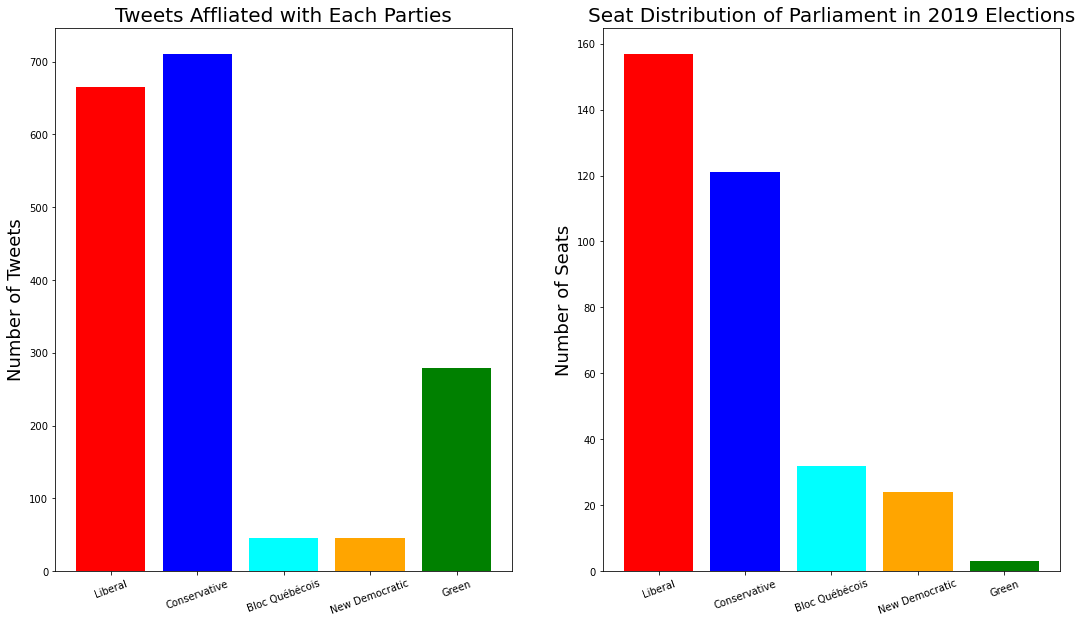

In [77]:
color = ['red','blue', 'cyan', 'orange', 'green' ]
seats = [157, 121, 32, 24, 3]

fig, axs = plt.subplots(1,2, figsize=(18, 10))
plt.sca(axs[0])

#calculate num of tweet for each party 
num_t = [] 
for party in parties:
    n_t = E_df[party].value_counts()[1]
    num_t.append(n_t)

x_tick = np.arange(len(parties))

plt.bar(x_tick, num_t, color = color)
axs[0].set_xticks(x_tick)
axs[0].set_xticklabels(parties, fontsize =10, rotation =20)
plt.ylabel('Number of Tweets', fontsize = 18)
plt.title("Tweets Affliated with Each Parties",fontsize = 20)

plt.sca(axs[1])
plt.bar(x_tick, seats, color =color)
axs[1].set_xticks(x_tick)
axs[1].set_xticklabels(parties, fontsize = 10, rotation =20)
plt.ylabel('Number of Seats', fontsize =18)
plt.title('Seat Distribution of Parliament in 2019 Elections', fontsize = 20)



### 2.2 Data Visualization 

#### 1) sentiment_analysis.csv: Frequent words in Positive Tweets

Tweets with positive sentiment from the sentiment_analysis.csv contains positive vocabularies such as 'love', 'happy', 'amazing', and 'happy bday'. 

Text(0.5, 1.0, 'Keywords of positive sentiment tweets from Sentiment.csv')

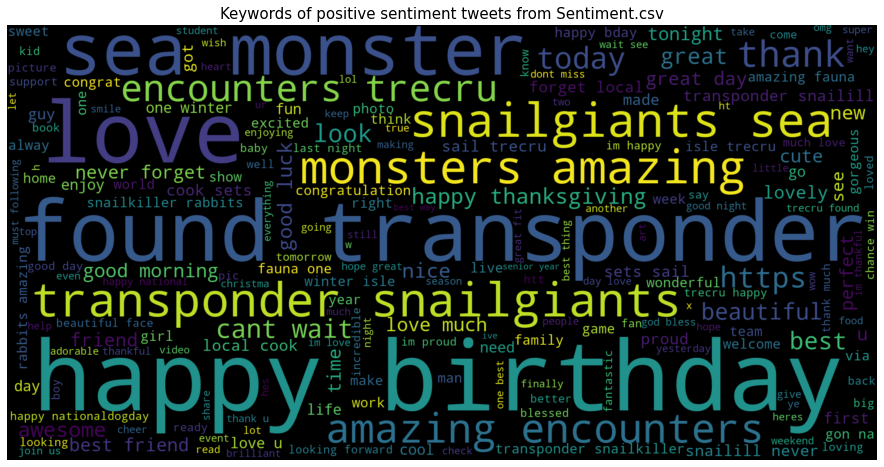

In [15]:
def split_list_into_word(tweet_list):
    words_list = []
    templist = []
    for i in range(len(tweet_list)):
        templist = tweet_list[i].split()
        for word in templist:
            words_list.append(word)
    return words_list

SA_df = SA.copy()
positive_SA = []

for i in range (SA_df.shape[0]):
    label = SA_df['label'][i]
    if label == 1:
        positive_SA.append(SA_df['text_c'][i])

positive_words_list = split_list_into_word(positive_SA)
positive_words_list = ' '.join(positive_words_list)

wordcloud = WordCloud(width=2000, height=1000).generate(positive_words_list)

plt.figure(figsize=(16,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Keywords of positive sentiment tweets from Sentiment.csv', fontsize=15)


#### 2) Canadian_Election_2019.csv: Frequent words in Positive Tweets
- Two of the most common words for the positive sentiment are elxn43 and cdnpoli. They are the hashtags that tagged to almost every tweet related to the election. They do not provide any meaningful information on the sentiment of the tweet. Instead, they have negative impacts on the prediction algorithms since they are the noise in the dataset.
- Apart from the noise words, the words showed up frequently are related to the Liberal party such as 'liberal', 'trudeau '. 

Text(0.5, 1.0, 'Keywords of positive sentiment tweets from Sentiment.csv')

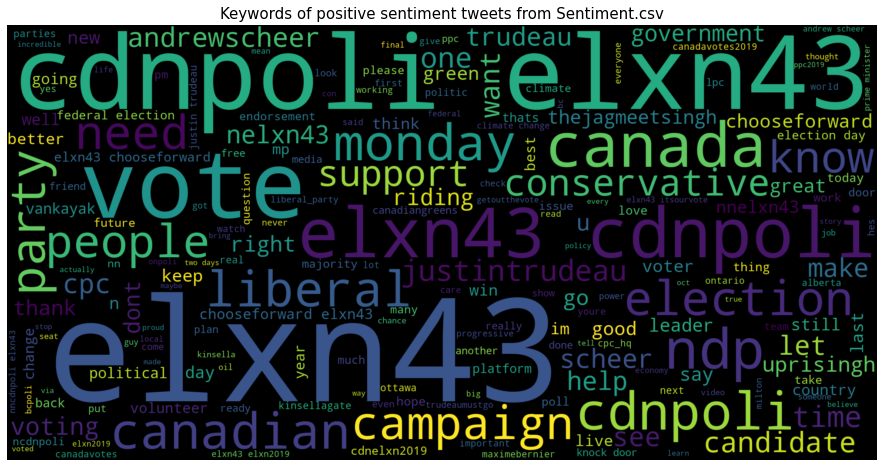

In [15]:
positive_SA = []

for i in range (E_df.shape[0]):
    sentiment = E_df['sentiment'][i]
    if sentiment == 'positive':
        positive_SA.append(E_df['text_c'][i])

positive_words_list = split_list_into_word(positive_SA)
positive_words_list = ' '.join(positive_words_list)

wordcloud = WordCloud(width=2000, height=1000).generate(positive_words_list)

plt.figure(figsize=(16,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Keywords of positive sentiment tweets from Sentiment.csv', fontsize=15)

#### 3) Canadian Election 2019: Sentiment Ratio of Tweets for each Party
The following observations are realized: 

- The ratio of positive sentiment and negative sentiment tweets for Liberal party is around 50:50.
- Majority of tweets affiliated with Conservative Party has a negative sentiment
- Majority of the tweets related with New Democratic party has negative sentiment. 
- Green has more positive tweets than negative ones

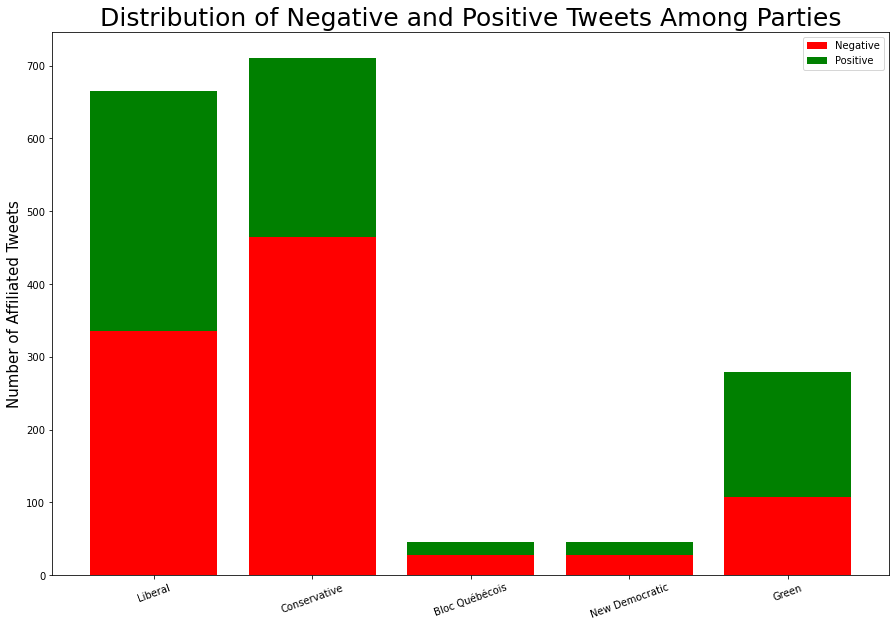

In [82]:
parties = ['Liberal', 'Conservative', 'Bloc Québécois', 'New Democratic', 'Green']
num_positive = []
num_t = [] 

for party in parties:
    n_t = E_df[party].value_counts()[1]
    num_t.append(n_t)
    count = 0
    for j in range(E_df.shape[0]):
        if E_df['sentiment'][j] == 'positive' and E_df[party][j] == 1:
            count+=1 
    num_positive.append(count)

num_t = np.array(num_t)
num_positive = np.array(num_positive)
num_negative = num_t - num_positive
idx = np.arange(len(parties))

plt.figure(figsize=(15,10))
plt.bar(idx, num_negative, color='red', label = 'Negative')
plt.bar(idx, num_positive, bottom = num_negative, color='green', label = 'Positive')
plt.xticks(idx, parties, fontsize=10, rotation = 20)
plt.ylabel('Number of Affiliated Tweets', fontsize = 15)
plt.title('Distribution of Negative and Positive Tweets Among Parties', fontsize = 25)
plt.legend()


## 3. Model Preparation 

Implement two different types of features, 1) word frequency (WF) 2)TF-IDF.

In [13]:
SA_df = copy.deepcopy(SA)
SA_df.drop(['text'], axis =1, inplace = True)
SA_df['label'].value_counts()

1    371341
0    179050
Name: label, dtype: int64

#### 3.1 Bag of Word (Word Frequency) Method

Bag of words model is a way of representing text data that describes the occurrence of words with a document(in this case in each tweet). 

In [20]:
from sklearn.feature_extraction.text import CountVectorizer

class WF_CV(object):
    def __init__(self,dataFrame):
        super().__init__()
        self.dataFrame = dataFrame
    
    def convert(self, text_col, label_col):
        return self.wf_convert(text_col, label_col)

    def wf_convert(self, text_col, label_col):
        wf_vectorizer = CountVectorizer(stop_words = 'english', max_features = 1000, max_df = 0.8)
        X = wf_vectorizer.fit_transform(self.dataFrame[text_col])
        y = self.dataFrame[label_col]
        return X, y 

In [21]:
WF_cvt = WF_CV(SA_df)
X_wf, y_wf = WF_cvt.convert('text_c', 'label')
X_wf 

<550391x1000 sparse matrix of type '<class 'numpy.int64'>'
	with 1890874 stored elements in Compressed Sparse Row format>

#### 3.2 TF-IDF

TFIDF is a numerical statistic that is intended to reflect how important a word is to a document in a collection or corpus.It is often used as a weighting factor in searches of information retrieval, text mining, and user modeling. The tf–idf value increases proportionally to the number of times a word appears in the document and is offset by the number of documents in the corpus that contain the word, which helps to adjust for the fact that some words appear more frequently in general.

In [16]:
class TFIDF_Convert(object):
    def __init__(self,dataFrame):
        super().__init__()
        self.dataFrame = dataFrame
    
    def convert(self, text_col, label_col):
        return self.tfidf_convert(text_col, label_col)

    def tfidf_convert(self, text_col, label_col):
        tfidf_vectorizer = TfidfVectorizer(stop_words = 'english', max_features = 2000, max_df = 0.8)
        X = tfidf_vectorizer.fit_transform(self.dataFrame[text_col])
        y = self.dataFrame[label_col]
        return X, y

In [17]:
TFIDF_cvt = TFIDF_Convert(SA_df)
X_tfidf, y_tfidf = TFIDF_cvt.convert('text_c', 'label')
X_tfidf 

<550391x2000 sparse matrix of type '<class 'numpy.float64'>'
	with 2237097 stored elements in Compressed Sparse Row format>

#### 3.2 Train-Test Split

In [24]:
#WF data
X_train_wf, X_test_wf , y_train_wf, y_test_wf = train_test_split( X_wf, y_wf, test_size = 0.3, random_state= 0, shuffle = False )

#TFIDF data
X_train_tf, X_test_tf, y_train_tf, y_test_tf = train_test_split( X_tfidf, y_tfidf, test_size = 0.3, random_state = 0, shuffle = False)

## 4. Model Implementation 

**Procedure**
1. Train with different classification algorithms on the sentiment_analysis.csv training dataset for both types of features. Obtain test accuracy on test set
2. Evaluate best model on election data
3. Choose best model and visualize the sentiment prediction result and true sentiment for 3 parties. Discuss results. 
4. Split negative election tweets to train (70%) and test (30%) sets, and choose 3 algorithms implemented in previous section to predict negative reason. Tune hyperparameters.  

### 4.1 Train and Test Algorithms on Generic Tweets (sentiment_analysis.csv)

The following classification algorithms are used for the sentiment prediction for each tweet:
1. Logistic Regression
2. k-Nearest Neighbors
3. Multinomial Naive Bayes 
4. Support Vector Machine 
5. Decision trees
6. Random Forest
7. XGboost

- Use GridSearchCV to find the optimal parameter(s), use 10 or 5 folds cross-validation.  
- Train model with optimal parameter(s), and get the test accuracy. 

**Summary of Results:** <br>

**TFIDF Features**

|Model|CV Score|Test Accuracy|
|-----|----- ---------- -----|---- --------|
|Logistic Regression|94.68%|94.68%|
|k-Nearest Neighbors|N.A.|83.21%|
|Multinomial Naive Bayes|90.99%|88.44%|
|**Support Vector Machine**|94.65%|**94.77%**|
|Decision trees|92.46%|92.57%|
|Random Forest|92.96%|93.93%|
|XGBoost|92.47%|94.33%|

**Work Frequency Features**

|Model|CV Score|Test Accuracy|
|-----|----- ---------- -----|---- --------|
|Logistic Regression|93.17%|93.7%|
|k-Nearest Neighbors|N.A.|91.59%|
|Multinomial Naive Bayes|89.64%|87.63%|
|**Support Vector Machine**|93.11%|**93.87%**|
|Decision trees|92.15%|92.6%|
|Random Forest|92.08%|93.33%|
|XGBoost|91.77%|93.48%|

Based on the test accuracy, the best classification is: SVM with TFIDF features -  LinearSVC(random_state =0, tol = 1e-5, C=0.1)


|Feature|Logistic Regression|k-NN|Multinomial Naive Bayes|**SVM**|Decision trees|Random Forest|XGBoost|
|-----|----- ---------- -----|---- --------|--|---|--|---|---|
|TFIDF| 94.68%|83.21%|88.44%|**94.77%**|92.57%|93.93%|94.33%|
|WF | 93.7%|91.59%|87.63%|93.87%|92.6%|93.33%|93.48%|

#### 1) Logistic Regression
Logistic regression is used to predict a nominal dependent variable given one or more independent variables. 

Hyperparameters tuned: C (inverse of the regularization strength) | solver <br>
**Optimal hyperparameters:** 

|Features|C|solver|CV Accuracy| Test Accuracy|
|-----|----------|---------|--------|----------|
|TFIDF|1.0|lbfgs|94.68%|94.68%|
|WF|10|lbfgs|93.17%|93.7%|


In [26]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
model_1 = LogisticRegression()
parameters = {'C': [0.01, 0.1, 1, 10, 50], 'solver': ('liblinear','lbfgs', 'newton-cg')}
clf = GridSearchCV(model_1, parameters, cv=10, n_jobs = -1)
clf.fit(X_train_tf, y_train_tf)

print('For TFIDF Features')
print('The optimal parameters are: \n', clf.best_params_)
print('With cross-validation accuracy of: {}%'.format(round(clf.best_score_*100,2)))

For TFIDF Features
The optimal parameters are: 
 {'C': 1, 'solver': 'lbfgs'}
With cross-validation accuracy of: 94.68%


In [27]:
model_1_opt = LogisticRegression(C =10 , solver = 'newton-cg')
model_1_opt.fit(X_train_tf, y_train_tf)
y_pred_1 = model_1_opt.predict(X_test_tf)
acc_1_tf = accuracy_score(y_test_tf, y_pred_1)

print('Test accuracy of logistic regression model on TFIDF features is: {}%'.format(round(acc_1_tf *100, 2)))

Test accuracy of logistic regression model on TFIDF features is: 94.68%


In [28]:
model_1 = LogisticRegression()
parameters = {'C': [0.01, 0.1, 1, 10], 'solver': ('liblinear','lbfgs', 'newton-cg')}
clf = GridSearchCV(model_1, parameters, cv=10, n_jobs = -1)
clf.fit(X_train_wf, y_train_wf)

print('For Word Frequency Features')
print('The optimal parameters are: \n', clf.best_params_)
print('With cross-validation accuracy of: {}%'.format(round(clf.best_score_*100,2)))

For Word Frequency Features
The optimal parameters are: 
 {'C': 10, 'solver': 'lbfgs'}
With cross-validation accuracy of: 93.17%


In [29]:
model_1_opt = LogisticRegression(C =10 , solver = 'lbfgs')
model_1_opt.fit(X_train_wf, y_train_wf)
y_pred_1 = model_1_opt.predict(X_test_wf)
acc_1_wf = accuracy_score(y_test_wf, y_pred_1)

print('Test accuracy of logistic regression model on word frequency features is: {}%'.format(round(acc_1_wf *100, 2)))

Test accuracy of logistic regression model on word frequency features is: 93.7%


#### 2) K Nearst Neighbors Model 
K-Nearest Neighbors is one of the most basic yet essential classification algorithms in Machine Learning. It belongs to the supervised learning domain and finds intense application in pattern recognition, data mining and intrusion detection.

**Note: Since k-NN is a supervised machine learning method and the training dataset is huge (93668x107692 sparse matrix), the cross-validation is not applied for hyperparameters tuning due to computation time. 

Hyperparameters tuned: n_neighbors <br>
**Optimal hyperparameters:** 

|Features|n_neighbors| Test Accuracy|
|-----|----------|--------|
|TFIDF|10000|83.21%|
|WF|100|91.59%|


In [56]:
from sklearn import neighbors
parameters = [ 100, 1000, 5000, 10000]
best_acc = 0
optimal_neighbors = 0

for n_neighbors in parameters:
    knn =  neighbors.KNeighborsClassifier(n_neighbors)
    knn.fit(X_train_tf, y_train_tf)
    y_pred = knn.predict(X_test_tf)
    test_acc = accuracy_score(y_test_tf, y_pred)
    
    if test_acc > best_acc:
        best_acc = test_acc
        optimal_neighbors = n_neighbors 

In [57]:
acc_2_tf = best_acc
print('For TFIDF features')
print('The optimal number of neighbors for the k-NN model is :', optimal_neighbors)
print('With test accuracy of: {}% '.format(round(acc_2_tf*100, 2)))

For TFIDF features
The optimal number of neighbors for the k-NN model is : 10000
With test accuracy of: 83.21% 


In [58]:
parameters = [ 100, 1000, 5000, 10000]
best_acc = 0
optimal_neighbors = 0

for n_neighbors in parameters:
    knn =  neighbors.KNeighborsClassifier(n_neighbors)
    knn.fit(X_train_wf, y_train_wf)
    y_pred = knn.predict(X_test_wf)
    test_acc = accuracy_score(y_test_wf, y_pred)
    
    if test_acc > best_acc:
        best_acc = test_acc
        optimal_neighbors = n_neighbors 

In [59]:
acc_2_tf = best_acc
print('For WF features')
print('The optimal number of neighbors for the k-NN model is :', optimal_neighbors)
print('With test accuracy of: {}% '.format(round(acc_2_tf*100, 2)))

For WF features
The optimal number of neighbors for the k-NN model is : 100
With test accuracy of: 91.59% 


#### 3) Multinomial Naive Bayes
The multinomial Naive Bayes classifier is suitable for classification with discrete features (e.g., word counts for text classification). The multinomial distribution normally requires integer feature counts. However, in practice, fractional counts such as tf-idf may also work.

Hyperparameters tuned: alpha (Additive (Laplace/Lidstone) smoothing parameter)<br>
**Optimal hyperparameters:** 

|Features|alpha|CV Accuracy|Test Accuracy|
|-----|----------|--------|--------------|
|TFIDF|1.0|90.99%|88.44%|
|WF|1.0|89.64%|87.63%|

In [30]:
from sklearn.naive_bayes import MultinomialNB

parameters = {'alpha': [0.01,.01, 1.0, 10, 100]}
model_3 = MultinomialNB()
clf = GridSearchCV(model_3, parameters, cv =10, n_jobs = -1)
clf.fit(X_train_tf, y_train_tf)

print('For TFIDF features')
print('The optimal parameters alpha for multinomial naive bayes model is: \n', clf.best_params_)
print('With cross-validation accuracy of: {}%'.format(round(clf.best_score_*100,2)))

For TFIDF features
The optimal parameters alpha for multinomial naive bayes model is: 
 {'alpha': 1.0}
With cross-validation accuracy of: 90.99%


In [31]:
model_3_opt = MultinomialNB(alpha=1.0)
model_3_opt.fit(X_train_tf, y_train_tf)
y_pred_3 = model_3_opt.predict(X_test_tf)
acc_3_tf = accuracy_score(y_test_tf, y_pred_3)

print('Test accuracy of multinomial naive bayes model on TFIDF is: {}%'.format(round(acc_3_tf *100, 2)))

Test accuracy of multinomial naive bayes model on TFIDF is: 88.44%


In [32]:
from sklearn.naive_bayes import MultinomialNB

parameters = {'alpha': [0.01,0.1, 1.0, 10, 100]}
model_3 = MultinomialNB()
clf = GridSearchCV(model_3, parameters, cv =10, n_jobs = -1)
clf.fit(X_train_wf, y_train_wf)

print('For WF features')
print('The optimal parameters alpha for multinomial naive bayes model is: \n', clf.best_params_)
print('With cross-validation accuracy of: {}%'.format(round(clf.best_score_*100,2)))

For WF features
The optimal parameters alpha for multinomial naive bayes model is: 
 {'alpha': 1.0}
With cross-validation accuracy of: 89.64%


In [33]:
model_3_opt = MultinomialNB(alpha=1.0)
model_3_opt.fit(X_train_wf, y_train_wf)
y_pred_3 = model_3_opt.predict(X_test_wf)
acc_3_wf = accuracy_score(y_test_wf, y_pred_3)

print('Test accuracy of multinomial naive bayes model on WF is: {}%'.format(round(acc_3_wf *100, 2)))

Test accuracy of multinomial naive bayes model on WF is: 87.63%


#### 4) Support Vector Machine
The objective of the support vector machine algorithm is to find a hyperplane in an N-dimensional space(N — the number of features) that distinctly classifies the data points. In this section, linear support vector classification (LinearSVC) is applied with the assumption that the dataset is linearly separable.

Hyperparameters tuned: C (inverse of the regularization strength)<br>
**Optimal hyperparameters:** 

|Features|alpha|CV Accuracy|Test Accuracy|
|-----|----------|--------|--------------|
|TFIDF|0.1|94.65%|94.77%|
|WF|0.1|93.11%|93.87%|

In [34]:
from sklearn.svm import LinearSVC

parameters = {'C': [0.01, 0.1, 1.0, 10, 100]}
model_4 = LinearSVC(random_state =0, tol = 1e-5)
clf = GridSearchCV(model_4, parameters, cv =10, n_jobs = -1)
clf.fit(X_train_tf, y_train_tf)

print('For TFIDF features')
print('The optimal parameters C for SVM model is: \n', clf.best_params_)
print('With cross-validation accuracy of: {}%'.format(round(clf.best_score_*100,2)))

For TFIDF features
The optimal parameters C for SVM model is: 
 {'C': 0.1}
With cross-validation accuracy of: 94.65%


In [35]:
model_4_opt = LinearSVC(random_state =0, tol = 1e-5, C=0.1)
model_4_opt.fit(X_train_tf, y_train_tf)
y_pred_4 = model_4_opt.predict(X_test_tf)
acc_4_tf = accuracy_score(y_test_tf, y_pred_4)

print('Test accuracy of SVM model on TFIDF features is: {}%'.format(round(acc_4_tf *100, 2)))

Test accuracy of SVM model on TFIDF features is: 94.77%


In [36]:
parameters = {'C': [0.01, 0.1, 1.0, 10, 100]}
model_4 = LinearSVC(random_state =0, tol = 1e-5)
clf = GridSearchCV(model_4, parameters, cv =10, n_jobs = -1)
clf.fit(X_train_wf, y_train_wf)

print('For WF features')
print('The optimal parameters C for SVM model is: \n', clf.best_params_)
print('With cross-validation accuracy of: {}%'.format(round(clf.best_score_*100,2)))

For WF features
The optimal parameters C for SVM model is: 
 {'C': 0.1}
With cross-validation accuracy of: 93.11%


In [38]:
model_4_opt = LinearSVC(random_state =0, tol = 1e-5, C=0.1)
model_4_opt.fit(X_train_wf, y_train_wf)
y_pred_4 = model_4_opt.predict(X_test_wf)
acc_4_wf = accuracy_score(y_test_wf, y_pred_4)

print('Test accuracy of SVM model on WF features is: {}%'.format(round(acc_4_wf *100, 2)))

Test accuracy of SVM model on WF features is: 93.87%


#### 5) Decision Tree Classifier 

Decision Trees (DTs) are a non-parametric supervised learning method used for classification and regression. The goal is to create a model that predicts the value of a target variable by learning simple decision rules inferred from the data features.

Hyperparameters tuned: min_samples_split (The minimum number of samples required to split an internal node)<br>
**Optimal hyperparameters:** 

|Features|min_samples_split|CV Accuracy|Test Accuracy|
|-----|----------|--------|--------------|
|TFIDF|2|92.46%|92.57%|
|WF|10|92.15%|92.6%|

In [39]:
from sklearn.tree import DecisionTreeClassifier

parameters = {'min_samples_split': [2,5,10]}
model_5 = DecisionTreeClassifier()
clf = GridSearchCV(model_5, parameters, cv =10, n_jobs = -1)
clf.fit(X_train_tf, y_train_tf)

print('For TFIDF features')
print('The optimal parameters C for decision tree model is: \n', clf.best_params_)
print('With cross-validation accuracy of: {}%'.format(round(clf.best_score_*100,2)))

For TFIDF features
The optimal parameters C for decision tree model is: 
 {'min_samples_split': 2}
With cross-validation accuracy of: 92.46%


In [42]:
model_5_opt = DecisionTreeClassifier(min_samples_split = 2)
model_5_opt.fit(X_train_tf, y_train_tf)
y_pred_5 = model_5_opt.predict(X_test_tf)
acc_5_tf = accuracy_score(y_test_tf, y_pred_5)

print('Test accuracy of decision tree model on TFIDF features is: {}%'.format(round(acc_5_tf *100, 2)))

Test accuracy of decision tree model on TFIDF features is: 92.57%


In [40]:
parameters = {'min_samples_split': [2,5,10]}
model_5 = DecisionTreeClassifier()
clf = GridSearchCV(model_5, parameters, cv =10, n_jobs = -1)
clf.fit(X_train_wf, y_train_wf)

print('For WF features')
print('The optimal parameters C for decision tree model is: \n', clf.best_params_)
print('With cross-validation accuracy of: {}%'.format(round(clf.best_score_*100,2)))

For WF features
The optimal parameters C for decision tree model is: 
 {'min_samples_split': 10}
With cross-validation accuracy of: 92.15%


In [43]:
model_5_opt = DecisionTreeClassifier(min_samples_split = 10 )
model_5_opt.fit(X_train_wf, y_train_wf)
y_pred_5 = model_5_opt.predict(X_test_wf)
acc_5_wf = accuracy_score(y_test_wf, y_pred_5)

print('Test accuracy of SVM model on WF features is: {}%'.format(round(acc_5_wf *100, 2)))

Test accuracy of SVM model on WF features is: 92.6%


#### 6) Random Forest Classifier 
Random forests has a variety of applications, such as recommendation engines, image classification and feature selection. It can be used to classify loyal loan applicants, identify fraudulent activity and predict diseases. It lies at the base of the Boruta algorithm, which selects important features in a dataset.

Hyperparameters tuned: min_samples_split (The minimum number of samples required to split an internal node)<br>
**Optimal hyperparameters:** 

|Features|min_samples_split|CV Accuracy|Test Accuracy|
|-----|----------|--------|--------------|
|TFIDF|10|92.96%|93.93%|
|WF|5|92.08%|93.33%|

In [44]:
from sklearn.ensemble import RandomForestClassifier

parameters = {'min_samples_split': [2,5,10]}
model_6 = RandomForestClassifier(random_state =0, n_estimators = 10)
clf = GridSearchCV(model_6, parameters, cv =5, n_jobs = -1)
clf.fit(X_train_tf, y_train_tf)

print('For TFIDF features')
print('The optimal parameters C for random forest model is: \n', clf.best_params_)
print('With cross-validation accuracy of: {}%'.format(round(clf.best_score_*100,2)))

For TFIDF features
The optimal parameters C for random forest model is: 
 {'min_samples_split': 10}
With cross-validation accuracy of: 92.96%


In [46]:
model_6_opt = RandomForestClassifier(random_state =0, n_estimators = 10, min_samples_split = 10)
model_6_opt.fit(X_train_tf, y_train_tf)
y_pred_6 = model_6_opt.predict(X_test_tf)
acc_6_tf = accuracy_score(y_test_tf, y_pred_6)

print('Test accuracy of random forest model on TFIDF feature is: {}%'.format(round(acc_6_tf *100, 2)))

Test accuracy of random forest model on TFIDF feature is: 93.93%


In [48]:
parameters = {'min_samples_split': [2,5,10]}
model_6 = RandomForestClassifier(random_state =0, n_estimators = 10)
clf = GridSearchCV(model_6, parameters, cv =5, n_jobs = -1)
clf.fit(X_train_wf, y_train_wf)

print('For WF features')
print('The optimal parameters C for random forest model is: \n', clf.best_params_)
print('With cross-validation accuracy of: {}%'.format(round(clf.best_score_*100,2)))

For WF features
The optimal parameters C for random forest model is: 
 {'min_samples_split': 5}
With cross-validation accuracy of: 92.08%


In [52]:
model_6_opt = RandomForestClassifier(random_state =0, n_estimators = 10, min_samples_split = 5)
model_6_opt.fit(X_train_wf, y_train_wf)
y_pred_6 = model_6_opt.predict(X_test_wf)
acc_6_wf = accuracy_score(y_test_wf, y_pred_6)

print('Test accuracy of random forest model on WF feature is: {}%'.format(round(acc_6_wf *100, 2)))

Test accuracy of random forest model on WF feature is: 93.33%


#### 7) XGBoost

XGBoost is an optimized distributed gradient boosting library designed to be highly efficient, flexible and portable. It implements machine learning algorithms under the Gradient Boosting framework. 

Hyperparameters tuned: max_depth (The maximum depth of the tree, used to control over-fitting as higher depth will allow model to learn relations very specific to a particular sample.)<br>

**Optimal hyperparameters:** 

|Features|max_depth|CV Accuracy|Test Accuracy|
|-----|----------|--------|--------------|
|TFIDF|10|92.47%|94.33%|
|WF|10|91.77%|93.48%|

In [49]:
parameters = {'max_depth': [2, 4, 6, 8, 10]}
model_7 = XGBClassifier()
clf = GridSearchCV(model_7, parameters,cv = 5,  n_jobs = -1)
clf.fit(X_train_tf, y_train_tf)

print('For TFIDF features')
print('The optimal parameters C for XGB model is: \n', clf.best_params_)
print('With cross-validation accuracy of: {}%'.format(round(clf.best_score_*100,2)))

[19:16:25] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
For TFIDF features
The optimal parameters C for XGB model is: 
 {'max_depth': 10}
With cross-validation accuracy of: 92.47%


In [53]:
model_7_opt = XGBClassifier(max_depth = 10 )
model_7_opt.fit(X_train_tf, y_train_tf)
y_pred_7 = model_7_opt.predict(X_test_tf)
acc_7_tf = accuracy_score(y_test_tf, y_pred_7)

print('Test accuracy of XGB model on TFIDF features is: {}%'.format(round(acc_7_tf *100, 2)))

[19:42:42] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Test accuracy of XGB model on TFIDF features is: 94.33%


In [62]:
parameters = {'max_depth': [2, 4, 6, 8, 10]}
model_7 = XGBClassifier()
clf = GridSearchCV(model_7, parameters,cv = 5,  n_jobs = -1)
clf.fit(X_train_wf, y_train_wf)

print('For WF features')
print('The optimal parameters C for XGB model is: \n', clf.best_params_)
print('With cross-validation accuracy of: {}%'.format(round(clf.best_score_*100,2)))

[22:10:22] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
For WF features
The optimal parameters C for XGB model is: 
 {'max_depth': 10}
With cross-validation accuracy of: 91.77%


In [60]:
model_7_opt = XGBClassifier(max_depth = 10)
model_7_opt.fit(X_train_wf, y_train_wf)
y_pred_7 = model_7_opt.predict(X_test_wf)
acc_7_wf = accuracy_score(y_test_wf, y_pred_7)

print('Test accuracy of XGB model on TFIDF features is: {}%'.format(round(acc_7_wf *100, 2)))

[22:02:37] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Test accuracy of XGB model on TFIDF features is: 93.48%


### 4.2 Evaluate Model on 2019 Election Data 

**Procedure**
1. Convert setiment to binary data: 1 = positive, 0 = negative
2. Apply WF or TFIDF feature method
3. Train-test split with test size of 0.3
4. Implement model 

**Result:**

- Training Accuracy: 69.38%
- Test Accuracy: 71.88% 

**Discussion:**

The SVM classification model performs moderately in prediction the sentiment for the 2019 Canadian election data with a test accuracy of 71.88%. The training accuracy (69.38%) is quite close to the test data, which means that there are no overfitting. 

In [51]:
E_tf = copy.deepcopy(Election)
E_tf.drop(['text'], axis =1, inplace = True)
E_tf['setiment'] = E_tf['sentiment'].replace(to_replace= ['positive', 'negative'],
                                                                    value=[1, 0]) 

In [52]:
TFIDF_cvt = TFIDF_Convert(E_tf)
X_tf_E, y_tf_E = TFIDF_cvt.convert('text_c', 'sentiment')
X_tf_E

<2133x2000 sparse matrix of type '<class 'numpy.float64'>'
	with 21693 stored elements in Compressed Sparse Row format>

In [53]:
X_train_E, X_test_E, y_train_E, y_test_E = train_test_split(X_tf_E, y_tf_E, test_size = 0.3,
                                                           random_state = 0, shuffle = False)

In [69]:
from sklearn.model_selection import cross_val_score
model_E = LinearSVC(random_state =0, tol = 1e-5, C=0.1)
model_E.fit(X_train_E, y_train_E)

scores = cross_val_score(model_E, X_train_E, y_train_E, cv=10)
print('Cross-Validation Accuracy Scores:{}%'.format(round(np.mean(scores)*100,2)))
y_pred_E = model_E.predict(X_test_E)
acc_E = accuracy_score(y_test_E, y_pred_E)

print('Test accuracy of Logistic model on TFIDF features is: {}%'.format(round(acc_E *100, 2)))

Cross-Validation Accuracy Scores:69.38%
Test accuracy of Logistic model on TFIDF features is: 71.88%


### 4.3 Visualize Sentiment Prediction Results and True Sentiment for each of the 3 Parties

**Procedures:**
1. Extract tweets related to the following 3 parties: Liberal, Conservative, Bloc Québécois
2. Train-test split with test size of 0.3
3. Train the Logistic Regression model with training set and test set
4. Visualize the sentiment prediction and true sentiment through confusion matrix

**Confusion Matrix:**

If the size of each classs in a multiclass dataset is unequal, classification accuracy alone can be misleading. Calculating a confusion matrix can provide a better idea of what the classification model is getting right and what types of error is occuring. 


**Result:**

|Party|Test Accuracy|Main Prediction Error|
|-----|------------|--------------|
|Liberal|64.50%|False Negative (FN)|
|Conservative|58.88%|False Negative (FN)|
|New Democratic|50.00%|False Negative (FN)|

**Discussion:**

- For all three parties, the main prediction error is false negative, in which the prediction model label the tweet with negative sentiment while its true sentiment is positive. 
- For Conservative and NDP, the model simply guess all tweets to have negative sentiment. these two models are simply making random guesses. This issue might be due to unbalance data.
-  The predictions made by the NLP analytics provide a general picture of the sentiments among the voters. However, the estimation of party's support rate should not be solely based the predictions made by the NLP analytics.

In [22]:
E_2 = copy.deepcopy(E_df)
E_2['sentiment'] = E_2['sentiment'].replace(to_replace=['positive', 'negative'], value = [1,0])
E_2.head()

,sentiment,negative_reason,text_c,Liberal,Conservative,Bloc Québécois,New Democratic,Green
0,0,Women Reproductive right and Racism,rosiebarton instead suggestion agree canadian ...,False,True,False,False,False
1,1,NaN,allwomanspacewalk realnspace_station netobicok...,False,False,False,False,False
2,0,Economy,brantford going cost 94 billion next 4 years a...,True,False,False,False,False
3,1,NaN,canada canadaelection2019 canadavotes nelxn43 ...,False,False,False,False,False
4,0,Economy,canada taxpayers sick tired hard earned donate...,True,False,False,False,False


#### 1) Liberal Party

In [37]:
E_lib = E_2.loc[E_2['Liberal']==1].copy()

In [38]:
Cvt = TFIDF_Convert(E_lib)
X_tf_lib, y_tf_lib = Cvt.convert('text_c', 'sentiment')

In [84]:
X_tf_lib

<665x2000 sparse matrix of type '<class 'numpy.float64'>'
	with 8734 stored elements in Compressed Sparse Row format>

In [39]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

X_train_lib, X_test_lib, y_train_lib, y_test_lib = train_test_split(X_tf_lib, y_tf_lib, test_size= 0.3,
                                                                  random_state= 0, shuffle=False )
model_lib = LinearSVC(random_state =0, tol = 1e-5, C=0.1)
model_lib.fit(X_train_lib, y_train_lib)
y_pred_lib =model_lib.predict(X_test_lib)

test_acc_lib = accuracy_score(y_test_lib, y_pred_lib)

print('Test accuracy of logistic regression model for Liberal party: {}%'.format(round(test_acc_lib*100,2)))


Test accuracy of logistic regression model for Liberal party: 64.5%


              precision    recall  f1-score   support

    Negative       0.55      0.78      0.65        83
    Positive       0.78      0.55      0.64       117

    accuracy                           0.65       200
   macro avg       0.67      0.67      0.64       200
weighted avg       0.69      0.65      0.64       200



Text(0.5, 1.0, 'Liberal Party Tweets Sentimenal Predictions')

<Figure size 432x288 with 0 Axes>

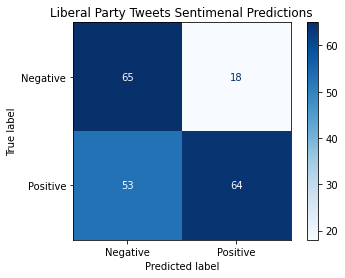

In [40]:
from sklearn.metrics import classification_report
print(classification_report(y_test_lib, y_pred_lib, target_names=['Negative', 'Positive']));
plt.figure()
plot_confusion_matrix(model_lib, X_test_lib, y_test_lib,  display_labels=['Negative', 'Positive'],
                     cmap=plt.cm.Blues)
plt.title('Liberal Party Tweets Sentimenal Predictions')

#### 2) Conservative Party

In [41]:
E_con = E_2.loc[E_2['Conservative']==1].copy()

In [42]:
Cvt = TFIDF_Convert(E_con)
X_tf_con, y_tf_con = Cvt.convert('text_c', 'sentiment')

In [43]:
X_train_con, X_test_con, y_train_con, y_test_con = train_test_split(X_tf_con, y_tf_con, test_size= 0.3,
                                                                  random_state= 0, shuffle=False )
model_con = LinearSVC(random_state =0, tol = 1e-5, C=0.1)
model_con.fit(X_train_con, y_train_con)
y_pred_con =model_con.predict(X_test_con)

test_acc_con = accuracy_score(y_test_con, y_pred_con)

print('Test accuracy of logistic regression model for Conservative party: {}%'.format(round(test_acc_con*100,2)))


Test accuracy of logistic regression model for Conservative party: 58.88%


              precision    recall  f1-score   support

    Negative       0.59      1.00      0.74       126
    Positive       0.00      0.00      0.00        88

    accuracy                           0.59       214
   macro avg       0.29      0.50      0.37       214
weighted avg       0.35      0.59      0.44       214



Text(0.5, 1.0, 'Conservative Party Tweets Sentimenal Predictions')

<Figure size 432x288 with 0 Axes>

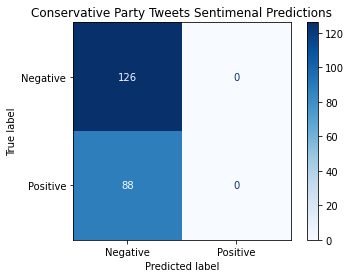

In [44]:
print(classification_report(y_test_con, y_pred_con, target_names=['Negative', 'Positive']));
plt.figure()
plot_confusion_matrix(model_con, X_test_con, y_test_con,  display_labels=['Negative', 'Positive'],
                     cmap=plt.cm.Blues)
plt.title('Conservative Party Tweets Sentimenal Predictions')

#### 3) New Democratic Party

In [45]:
E_nd = E_2.loc[E_2['New Democratic']==1].copy()

In [46]:
Cvt = TFIDF_Convert(E_nd)
X_tf_nd, y_tf_nd = Cvt.convert('text_c', 'sentiment')

In [47]:
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score

In [48]:
X_train_nd, X_test_nd, y_train_nd, y_test_nd = train_test_split(X_tf_nd, y_tf_nd, test_size= 0.3,
                                                                  random_state= 0, shuffle=False )
model_nd = LinearSVC(random_state =0, tol = 1e-5, C=0.1)
model_nd.fit(X_train_nd, y_train_nd)
y_pred_nd =model_nd.predict(X_test_nd)

test_acc_nd = accuracy_score(y_test_nd, y_pred_nd)

print('Test accuracy of logistic regression model for NDP: {}%'.format(round(test_acc_nd*100,2)))


Test accuracy of logistic regression model for NDP: 50.0%


              precision    recall  f1-score   support

    Negative       0.50      1.00      0.67         7
    Positive       0.00      0.00      0.00         7

    accuracy                           0.50        14
   macro avg       0.25      0.50      0.33        14
weighted avg       0.25      0.50      0.33        14



Text(0.5, 1.0, 'NDP Tweets Sentimenal Predictions')

<Figure size 432x288 with 0 Axes>

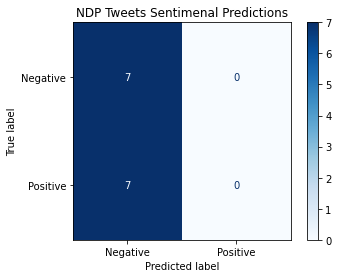

In [68]:
print(classification_report(y_test_nd, y_pred_nd, target_names=['Negative', 'Positive']));
plt.figure()
plot_confusion_matrix(model_nd, X_test_nd, y_test_nd,  display_labels=['Negative', 'Positive'],
                     cmap=plt.cm.Blues)
plt.title('NDP Tweets Sentimenal Predictions')

### 4.4 Multiclass Classifcation on Negative Sentiment Reason 

**Procedure**
1. Extract tweets with negative sentiment 
2. Encode the 10 negative reasons with numerical values
3. Apply TFIDF method to create feature
4. Choose 3 algorithms based on test accuracy and implement (SVM,logistic regression, XGBoost with TFIDF features)

**Results:** <br>

|Model|Parameter(s)|Train Accuracy|Test Accuracy|
|-------- --------|---- --------|----|----|
|SVM|C = 1.0|48.71%|52.32%|
|Logistic Regreesion|C = 10, solver = liblinear|48.71%|51.32%|
|XGBoost|max_depth = 2|49.2%|56.62%|

In [54]:
E_3 = E_tf.copy()
E_3['sentiment'] = E_3['sentiment'].replace(to_replace=['positive', 'negative'], value = [1,0])
E_neg = E_3.loc[E_3['sentiment']== 0].copy()
E_neg.head()

,sentiment,negative_reason,text_c,setiment
0,0,Women Reproductive right and Racism,rosiebarton instead suggestion agree canadian ...,0
2,0,Economy,brantford going cost 94 billion next 4 years a...,0
4,0,Economy,canada taxpayers sick tired hard earned donate...,0
5,0,Others,canadavotes2019 elxn43 cdnpoli facts blastfrom...,0
8,0,Others,chooseforward cdnpoli elxn43ncanada dont make ...,0


In [55]:
E_neg['negative_reason'].value_counts()

Others                                 364
Scandal                                270
Tell lies                              198
Economy                                 51
Women Reproductive right and Racism     45
Climate Problem                         41
Separation                              16
Privilege                               12
Healthcare                               5
Healthcare and Marijuana                 4
Name: negative_reason, dtype: int64

Text(0.5, 1.0, 'Distribution of Negative Reasons for Tweets')

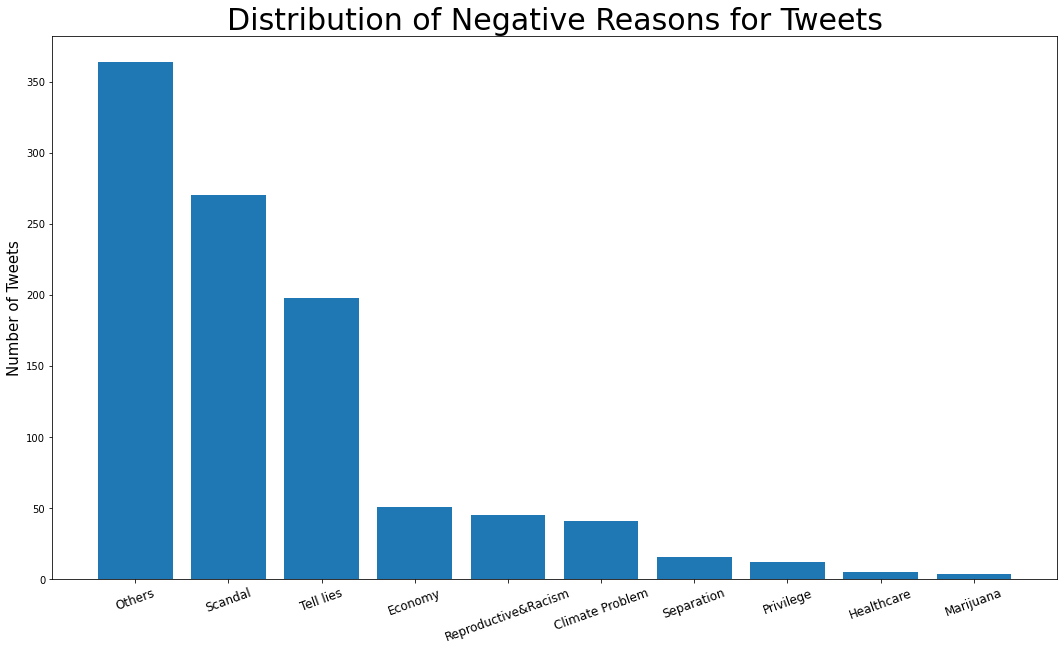

In [119]:

reasons = ['Others', 'Scandal', 'Tell lies', 'Economy','Women Reproductive right and Racism', 
           'Climate Problem','Separation','Privilege','Healthcare', 'Healthcare and Marijuana']

num_t = [] 
for reason in range(0,10):
    n_t = E_neg['negative_reason'].value_counts()[reason]
    num_t.append(n_t)
reasons =  ['Others', 'Scandal', 'Tell lies', 'Economy', 'Reproductive&Racism', 
           'Climate Problem','Separation','Privilege','Healthcare', 'Marijuana']
x_tick = np.arange(len(reasons))

plt.figure(figsize=(18,10))
plt.bar(x_tick, num_t)
plt.xticks(x_tick, reasons, fontsize=12, rotation = 20)
plt.ylabel('Number of Tweets', fontsize = 15)
plt.title("Distribution of Negative Reasons for Tweets", fontsize = 30)

In [107]:
num_t, x_tick

([364, 270, 198, 51, 45, 41, 16, 12, 5, 4],
 array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]))

In [56]:
def reason_encoder (value):
    mapdict = {'Others': 0, 'Scandal': 1, 'Tell lies': 2, 'Economy':3,
               'Women Reproductive right and Racism':4, 'Climate Problem':5, 
               'Separation':6, 'Privilege':7, 'Healthcare':8, 'Healthcare and Marijuana':9}
    
    return mapdict[value]

E_neg['negative_reason'] = E_neg['negative_reason'].apply(reason_encoder)
E_neg.head(3)

,sentiment,negative_reason,text_c,setiment
0,0,4,rosiebarton instead suggestion agree canadian ...,0
2,0,3,brantford going cost 94 billion next 4 years a...,0
4,0,3,canada taxpayers sick tired hard earned donate...,0


In [87]:
E_neg

,sentiment,negative_reason,text_c,setiment
0,0,4,rosiebarton instead suggestion agree canadian ...,0
2,0,3,brantford going cost 94 billion next 4 years a...,0
4,0,3,canada taxpayers sick tired hard earned donate...,0
5,0,0,canadavotes2019 elxn43 cdnpoli facts blastfrom...,0
8,0,0,chooseforward cdnpoli elxn43ncanada dont make ...,0
...,...,...,...,...
2125,0,0,cant supervillain election failed jobs nnelxn43,0
2126,0,5,care limiting climatechange wondering party vo...,0
2128,0,1,know good enough job smearing campaign right a...,0
2129,0,1,missed comment deflecting issue answer best re...,0


In [57]:
cvt = TFIDF_Convert(E_neg)
X_neg, y_neg = cvt.convert('text_c', 'negative_reason')
X_train_neg, X_test_neg, y_train_neg, y_test_neg = train_test_split(X_neg, y_neg, test_size=0.3,
                                                                   random_state = 0, shuffle = False)

#### 1) SVM 

In [61]:
from sklearn.svm import LinearSVC

parameters = {'C': [0.01, 0.1, 1.0, 10, 100]}
model_neg1 = LinearSVC(random_state =0, tol = 1e-5)
clf = GridSearchCV(model_neg1, parameters, cv =10, n_jobs = -1)
clf.fit(X_train_neg, y_train_neg)

print('For TFIDF features')
print('The optimal parameters C for SVM model is: \n', clf.best_params_)
print('With cross-validation accuracy of: {}%'.format(round(clf.best_score_*100,2)))

For TFIDF features
The optimal parameters C for SVM model is: 
 {'C': 1.0}
With cross-validation accuracy of: 48.71%


In [63]:
model_neg1 =LinearSVC(random_state =0, tol = 1e-5, C=1.0)
model_neg1.fit(X_train_neg, y_train_neg)
y_pred_neg1 = model_neg1.predict(X_test_neg)
acc_neg1 = accuracy_score(y_test_neg, y_pred_neg1)

print('Test accuracy of SVM model on TFIDF features for negative reason is: {}%'.format(round(acc_neg1 *100, 2)))

Test accuracy of SVM model on TFIDF features for negative reason is: 52.32%


#### 2) Logistic Regression

In [66]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
model_neg2 = LogisticRegression()
parameters = {'C': [0.01, 0.1, 1, 10, 50], 'solver': ('liblinear','lbfgs', 'newton-cg')}
clf = GridSearchCV(model_neg2, parameters, cv=10, n_jobs = -1)
clf.fit(X_train_neg, y_train_neg)

print('For TFIDF Features')
print('The optimal parameters are: \n', clf.best_params_)
print('With cross-validation accuracy of: {}%'.format(round(clf.best_score_*100,2)))

For TFIDF Features
The optimal parameters are: 
 {'C': 10, 'solver': 'liblinear'}
With cross-validation accuracy of: 48.71%


In [60]:
model_neg2 =LogisticRegression(C =10 , solver = 'liblinear')
model_neg2.fit(X_train_neg, y_train_neg)
y_pred_neg2 = model_neg2.predict(X_test_neg)
acc_neg2 = accuracy_score(y_test_neg, y_pred_neg2)

print('Test accuracy of XGBoost model on TFIDF features for negative reason is: {}%'.format(round(acc_neg2 *100, 2)))

Test accuracy of XGBoost model on TFIDF features for negative reason is: 51.32%


#### 3) XGBoost 

In [64]:
parameters = {'max_depth': [2, 4, 6, 8, 10]}
model_neg3 = XGBClassifier()
clf = GridSearchCV(model_neg3, parameters,cv = 5,  n_jobs = -1)
clf.fit(X_train_neg, y_train_neg)

print('For TFIDF features')
print('The optimal parameters C for XGB model is: \n', clf.best_params_)
print('With cross-validation accuracy of: {}%'.format(round(clf.best_score_*100,2)))

[16:27:56] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
For TFIDF features
The optimal parameters C for XGB model is: 
 {'max_depth': 2}
With cross-validation accuracy of: 49.0%


In [67]:
model_neg3 =XGBClassifier(max_depth =2 )
model_neg3.fit(X_train_neg, y_train_neg)
y_pred_neg3 = model_neg3.predict(X_test_neg)
acc_neg3 = accuracy_score(y_test_neg, y_pred_neg3)
print('Test accuracy of XGBoost model on TFIDF features for negative reason is: {}%'.format(round(acc_neg3 *100, 2)))

[16:31:15] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Test accuracy of XGBoost model on TFIDF features for negative reason is: 56.62%


## 5. Discussion

##### 1) For the first model which predicts the sentiment for each party
**Observations and discussion:**

- From third figure presented in section 2.2, we can observed that Liberal party receives approximately the same number of positive and negative comments. The Conservative party receives more negative comments than positive comments. The New Democratic party receives more negative comments than positive comments as well. 

- Based on the number of tweets and the number of positive tweets, the public pays most of the attention to the Liberal and Conservative parties.The election result also reflects that. 

- The NLP analytics using SVM model yields a cross-validation training accuracy of 63.38% and a test accuracy of 71.88%. The test accuracy of 71.88% is high enough to provide a general picture of the public sentiment towards the politics. Therefore, the NLP analytics may be used for estimating the general sentiment among the voters, but the election strategy should not solely depend on the predictions made by the NLP analytics since 71.88% is not high enough to predict perfectly. 

- The SVM model is applied to predict the sentiment for each of the three parties. The performance was bad. The main reason of the worsen performance is underfitting and unbalance data, due to lack of training samples. For example, the Conservative and NDP model predict all tweets to be negative. 

**Improvements**

- One way to improve the svm model is to ensembling multiple SVM. Feature selection is important to the application of SVM. One way to improve the performance of the model is to modify the feature selection feature extraction (tfidf) algorithm. 

- SVM model applied on the dataset for each of 3 parties has an underfitting problem since its test accuracy is low. One improvement is to increase the number of training samples for each party. 

##### 2) For the second model which predicts the sentiment label for each negative sentiment

**Observations and discussion:**

- Among all three algorithms (Support Vector MachineLogistic Regression, XGBoost), the XGBoost has the highest test accuracy, which is 56.62%.

- Probable poor performance reason: 
    
 1) Lack of training samples. There are in total 10 categories for negative reasons, however the training dataset is unbalanced and some categories only has few training samples available. For example, the 'Healthcare' only has 5 training samples and the 'Privilege' only has 12 training samples.
 
 2) Noise in the original dataset. The noise causes the algorithm to reach high complexity. For example, the hashtags such as #elxn43 and #cndpoli provide no meaningful information to the algorithm and negatively impact the model performance.
 
 3) The category 'Others' can be more specified. The model implemented mainly make the prediction to be 0 or 1. A more detailed classification that converts 'Others' into small sub-categories may improve the performance.

**Improvements:**

- Use a balanced dataset with larger number (such as at least 300) of training samples for each category.
- Improve feature selection algorithm to better eliminate features that are not useful to the prediction.  

In [69]:
y_pred_neg2

array([0, 0, 1, 0, 0, 2, 0, 1, 0, 1, 2, 0, 2, 3, 0, 1, 1, 0, 0, 0, 2, 1,
       1, 0, 0, 1, 2, 0, 2, 1, 0, 1, 0, 0, 0, 2, 2, 1, 0, 0, 1, 5, 0, 1,
       0, 0, 0, 1, 0, 1, 2, 0, 0, 0, 5, 0, 1, 1, 0, 0, 0, 5, 0, 0, 0, 0,
       0, 2, 0, 0, 0, 2, 0, 0, 1, 1, 0, 0, 2, 0, 0, 0, 1, 2, 0, 1, 0, 1,
       0, 2, 4, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 0,
       1, 1, 1, 1, 2, 1, 1, 1, 1, 0, 0, 0, 0, 6, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 2, 2, 1, 1, 2, 4, 0, 1, 2, 0, 1,
       1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 2, 1, 1, 2, 1, 0, 0, 0, 2, 0, 0,
       2, 1, 1, 2, 0, 0, 0, 0, 1, 1, 1, 2, 0, 0, 1, 0, 5, 2, 0, 2, 2, 0,
       1, 1, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 2, 1, 2, 1, 0, 2, 0, 0, 0, 1,
       0, 0, 0, 2, 0, 1, 0, 0, 0, 2, 0, 4, 1, 0, 2, 2, 0, 0, 1, 2, 0, 1,
       1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 4, 2, 0, 1,
       1, 1, 0, 1, 1, 2, 2, 0, 2, 1, 0, 0, 2, 1, 0, 2, 1, 0, 0, 0, 0, 0,
       0, 2, 0, 1, 0, 0, 2, 0, 0, 0, 0, 0, 5, 1, 1,

In [70]:
y_test_neg

1386    0
1389    1
1392    0
1393    0
1395    2
       ..
2125    0
2126    5
2128    1
2129    1
2131    4
Name: negative_reason, Length: 302, dtype: int64

In [71]:
print('The predicted reason for sample 1389 is:', y_pred_neg2[1], 'Others')
print('The true reason is :', E_3.loc[1389]['negative_reason'])

The predicted reason for sample 1389 is: 0 Others
The true reason is : Scandal


In [75]:
print('The predicted reason for sample 1392 is:', y_pred_neg2[2], 'Scandal')
print('The true reason is:', E_3.loc[1392]['negative_reason'])

The predicted reason for sample 1392 is: 1 Scandal
The true reason is: Others
